In [1]:
# !python -m pip install -r ../requirements.txt
# !python -m pip install -e ../libs
!python -m pip install scikit-image==0.22.0

  Using cached imageio-2.34.0-py3-none-any.whl.metadata (4.9 kB)
  Using cached tifffile-2024.2.12-py3-none-any.whl.metadata (31 kB)
  Using cached lazy_loader-0.3-py3-none-any.whl.metadata (4.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 39.0 MB/s eta 0:00:0000:0100:01
Using cached imageio-2.34.0-py3-none-any.whl (313 kB)
Using cached lazy_loader-0.3-py3-none-any.whl (9.1 kB)
Using cached tifffile-2024.2.12-py3-none-any.whl (224 kB)


References:
- Morphology: (opencv)[https://docs.opencv.org/4.x/dd/dd7/tutorial_morph_lines_detection.html]
- Morphological Transformations (opencv)[https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html]
- Canny Edge (opencv)[https://docs.opencv.org/4.x/d7/de1/tutorial_js_canny.html]
- Adaptive Thresholding (opencv)[https://homepages.inf.ed.ac.uk/rbf/HIPR2/adpthrsh.htm], (opencv)[https://docs.opencv.org/4.x/d7/dd0/tutorial_js_thresholding.html#]
- Remove horizontal lines: (stackoverflow)[https://stackoverflow.com/questions/71425968/remove-horizontal-lines-with-open-cv]

In [3]:
from binsense import metadata, downloader

# download Amazon bin images & meta-data
downloader.download()
# load meta-data to pandas
bin_df, item_df = metadata.load()

loading bin-metadata: 100%|██████████| 3875/3875 [00:47<00:00, 81.77it/s] 


In [11]:
import numpy as np
import cv2 as cv
import skimage

from matplotlib import pyplot as plt

def show_img(title, cv_img, ax):
    if ax is None:
        ax = plt.gca()
    ax.imshow(cv.cvtColor(cv_img, cv.COLOR_BGR2RGB))
    ax.set_title(title)

def grap_pixels_in_countor(img, cnt):
    cimg = np.zeros_like(img)
    cv.drawContours(cimg, [cnt], 0, color=255, thickness=cv.FILLED)
    
    # Access the image pixels and create a 1D numpy array then add to list
    pts = np.where(cimg == 255)
    return img[pts[0], pts[1]], pts

def mean_color(pixels):
    return np.round(np.mean(pixels, axis=0), 0)

def dominant_color(pixels):
    data = np.float32(pixels)
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv.KMEANS_RANDOM_CENTERS
    _,_,centers = cv.kmeans(data,K=1,bestLabels=None,criteria=criteria,attempts=10,flags=flags)
    
    return centers[0].astype(np.int32)

def blend_contour_color(img, pixel_locs_cnts):
    img_copy = np.copy(img)
    img_copy = img_copy / 255
    for cnt in pixel_locs_cnts:
        img_copy[cnt[0], cnt[1]] = np.nan
    
    def nangaussian(U, sigma=1, truncate=4.0):
        V = U.copy()
        V[np.isnan(U)] = 0
        # VV = cv.GaussianBlur(U, (21, 21), 10.0)
        VV = skimage.filters.gaussian(V, sigma=sigma, truncate=truncate, preserve_range=True)
        
        W = 0*U.copy()+1
        W[np.isnan(U)] = 0
        # WW = cv.GaussianBlur(U, (21,21), 10.0)
        WW = skimage.filters.gaussian(W, sigma=sigma, truncate=truncate, preserve_range=True)
        return VV / WW
    smooth = nangaussian(img_copy, sigma=1, truncate=4.0)
    
    # do not smooth full image but only copy smoothed NaN spots
    fill = img.copy()
    for cnt in pixel_locs_cnts:
        fill[cnt[0], cnt[1]] = (smooth[cnt[0], cnt[1]] * 255).astype(np.uint8)
    return fill

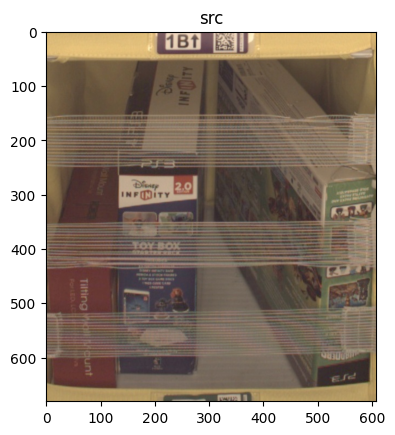

In [12]:
from binsense import config as cfg
import os

# df_sample = bin_df[bin_df['bin_image_kb'] >75].sample(n=1)
df_sample = bin_df[bin_df['bin_id'] == '109617']
img_path = os.path.join(cfg.BIN_S3_DOWNLOAD_IMAGES_DIR, df_sample['bin_image_name'].iloc[0])

src = cv.imread(img_path, cv.IMREAD_COLOR)
show_img("src", src, plt.gca())

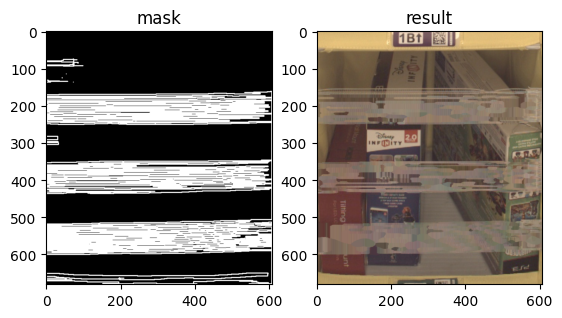

In [19]:
import cv2 as cv

# print('src shape:', src.shape)
gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
# print('gray shape:', src.shape)
# show_img("gray", cv.cvtColor(gray, cv.COLOR_BGR2RGB))


# Apply adaptiveThreshold at the bitwise_not of gray, notice the ~ symbol
gray = cv.bitwise_not(gray)
bw = cv.adaptiveThreshold(
    gray, 255, cv.ADAPTIVE_THRESH_MEAN_C,
    cv.THRESH_BINARY, 15, -2)
# show_img("bw", cv.cvtColor(bw, cv.COLOR_BGR2RGB))

horizontal = np.copy(bw)
cols = horizontal.shape[1]
horizontal_size = cols // 30
# Create structure element for extracting horizontal lines through morphology operations
horizontalStructure = cv.getStructuringElement(cv.MORPH_RECT, (horizontal_size, 1))
# # Apply morphology operations
# horizontal = cv.erode(horizontal, horizontalStructure)
# horizontal = cv.dilate(horizontal, horizontalStructure)
# show_img("horizontal", cv.cvtColor(horizontal, cv.COLOR_BGR2RGB))

detected_lines = cv.morphologyEx(horizontal, cv.MORPH_CLOSE, horizontalStructure, iterations=3)
cnts, _ = cv.findContours(detected_lines, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
# print(len(cnts), cnts[0].shape)
cnt_img = np.copy(src)
cnt1_img = np.copy(src)
mask = np.zeros(gray.shape, np.uint8)
colors = []
pixel_locs_cnts = []
for i, c in enumerate(cnts):
    in_cnt_pixels, cnt_pixel_locs = grap_pixels_in_countor(src, c)
    # dcolor = dominant_color(in_cnt_pixels)
    mcolor = mean_color(in_cnt_pixels)
    colors.append(np.array(mcolor))
    pixel_locs_cnts.append(cnt_pixel_locs)
    #print("top color:", dcolor, ", mean color:", mcolor)
    if mcolor[0] in range(60, 100) and mcolor[1] in range(70, 110) and mcolor[2] in range(90, 130):
        cv.drawContours(cnt_img, [c], -1, (255,255,255), 2)
        cv.drawContours(mask, [c], -1, (255,255,255), 2)
        
    cv.drawContours(cnt1_img, [c], -1, (255,255,255), 2)

fig, (ax1, ax2) = plt.subplots(1, 2)
show_img("mask", mask, ax1)
# show_img("horizontal", cnt_img)
# show_img("horizontal", cnt1_img)
f_img = cv.inpaint(src, mask, 0.5, cv.INPAINT_NS)
# f_img = blend_contour_color(src, pixel_locs_cnts)
show_img("result", f_img, ax2)

# colors = np.array(colors)
# print(np.min(colors, axis=0), np.max(colors, axis=0))

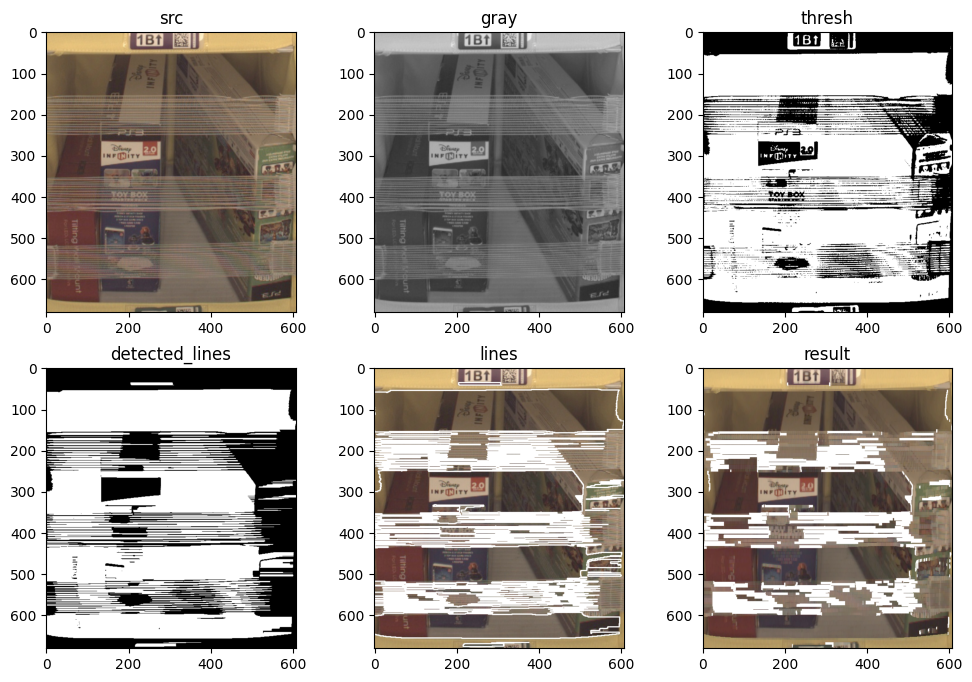

In [17]:
import cv2

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

src = cv2.imread(img_path)
show_img("src", src, axs[0][0])

image = src.copy()
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
show_img("gray", gray, axs[0][1])
show_img("thresh", thresh, axs[0][2])

# Remove horizontal
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,1))
detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(image, [c], -1, (255,255,255), 2)
show_img('detected_lines', detected_lines, axs[1][0])
show_img('lines', image, axs[1][1])

# Repair image
repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,6))
result = 255 - cv2.morphologyEx(255 - image, cv2.MORPH_CLOSE, repair_kernel, iterations=1)
show_img('result', result, axs[1][2])

plt.show()